## California State University, East Bay - Center for Student Research - (CSUEB - CSR)  
### Parallel Statistical Computing - Fall 2017
### Mentors: Prof. Eric Suess and Bruce Trumbo
### Student: Gui Larangeira


As an example, our goal is to construct a Gibbs Sampler for the multivariate target distribution. (This is a trivial non-Bayesian example of a Gibbs Sampler just to show how it works.) Later, we will apply to more interesting Bayesian examples.

$$ f(x,y) = kx^2\exp\{-xy^2-y^2+2y-4x\}, \hspace{1cm} x>0, y \in \mathbb{R}$$

where $k>0$ is an unknown normalizing constant that ensures the distribution integrates to 1. To construct a Gibbs Sampler we have to be able to sample from both the full conditional distributions $x|y$ and $y|x$, so let's derive those first before attempting to implement it.

The full conditionals are obtained by dividing the joints by the marginals:
$$ f(x|y) = \frac{f(x,y)}{f(y)} \hspace{1cm} f(y|x) = \frac{f(x,y)}{f(x)}$$

So let's calculate the full conditionals by obtaining the marginals in each case:

$$f(y)=\int_{0}^{\infty}kx^2\exp\left\{-xy^2-y^2+2y-4x\right\}dx = $$
$$ = k\exp\left\{2y-y^2\right\}\int_{0}^{\infty}x^2\exp\left\{-x(y^2+4)\right\}dx$$

We can consider $m=y^2+4$ a constant and effect the change of variable $u=mx$:

$$ f(y) = k\exp\left\{2y-y^2\right\}\int_{0}^{\infty}\frac{u}{m}^2\exp\{-u\}\frac{du}{m} = $$
$$      = k\exp\left\{2y-y^2\right\}\frac{1}{m^3}\int_{0}^{\infty}u^2\exp\{-u\}du = $$
$$      = k\exp\left\{2y-y^2\right\}\left(\frac{1}{y^2+4}\right)^{3}\Gamma(3)$$


So that 
$$ f(x|y) = \frac{kx^2\exp\left\{-xy^2-y^2+2y-4x\right\}}{2k\exp\left\{2y-y^2\right\}\left(\frac{1}{y^2+4}\right)^3}=$$
$$ = \frac{x^2}{2}\left(y^2+4\right)^3\exp\left\{-xy^2-y^2+2y-4x-2y+y^2\right\}=$$
$$ = x^2(y^2+4)^3\exp\left\{-x(y^2+4)\right\}$$
$$ = \Gamma\left(\alpha=3,\theta=\frac{1}{y^2+4}\right)$$

Similarly, we calculate the marginal $f(x)$ and the full conditional $f(y|x)$

$$f(x)=kx^2\exp(-4x)\int_{-\infty}^{\infty}\exp\left\{-y^2(x+1)+2y\right\}dy$$

The integral is a well known result, fortunately: https://en.wikipedia.org/wiki/Gaussian_function#Integral_of_a_Gaussian_function

$$\int_{-\infty}^{\infty}e^{-ax^2+bx+c}dy=\sqrt{\frac{\pi}{a}}e^{\frac{b^2}{4a}+c}$$

So our marginal now becomes
$$ f(x) = kx^2\exp\left\{-4x\right\}\sqrt\frac{\pi}{x+1}\exp\left\{\frac{1}{x+1}\right\}$$

And the conditional is
$$f(y|x)=\frac{f(x,y)}{f(x)}=\frac{kx^2\exp\left\{-xy^2-y^2+2y-4x\right\}}{kx^2\sqrt{\frac{\pi}{x+1}}\exp\left\{-4x+\frac{1}{x+1}\right\}}=$$
$$=\frac{1}{\sqrt{\pi\frac{1}{x+1}}}\exp\left\{-xy^2-y^2+2y-4x+4x-\frac{1}{x+1}\right\}$$
$$=\frac{1}{\sqrt{2\pi\frac{1}{2(x+1)}}}\exp\left\{-y^2(x+1)+2y-\frac{1}{x+1}\right\}$$
$$=\frac{1}{\sqrt{2\pi\frac{1}{2(x+1)}}}\exp\left\{-\frac{\left(y-\frac{1}{x+1}\right)^2}{2\frac{1}{2(x+1)}}\right\}$$
$$=\mathcal{N}\left(\frac{1}{1+x},\frac{1}{2(1+x)}\right)$$

With the conditionals in hand, let's now implement the GS computational method, beginning in R, then in Scala and timing each implementation:

   user  system elapsed 
  7.139   0.011   7.151 

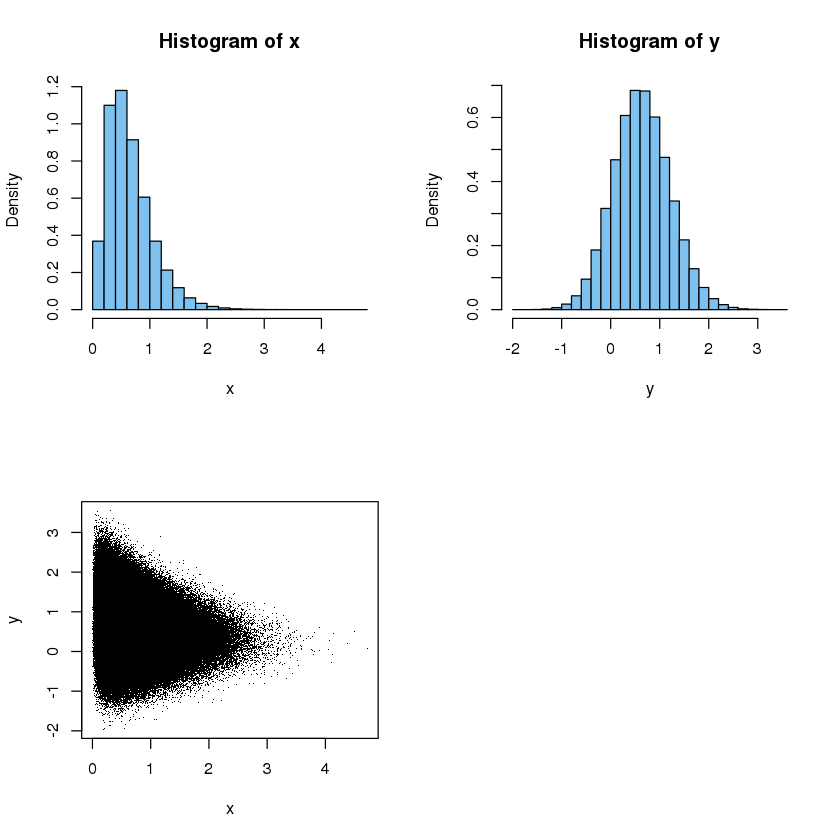

In [12]:
Rgibbs <- function(N,B) {
  mat <- matrix(0,nrow=N,ncol=2)
  x <- y <- 0
  for (i in 1:N) {
    
    x <- rgamma(1,3,y*y + 4) 
    y <- rnorm(1,1/(x + 1),1/sqrt(2*(x + 1)))
      
    mat[i,] <- c(x,y)
     }
  return(mat[-(1:B),])
}

system.time(rgs<-Rgibbs(1000000,500))
x=rgs[,1];y=rgs[,2]; z=c(x,y)
par(mfrow=c(2,2))
hist(x, prob=T, br=20,col="skyblue2")
hist(y, prob=T, br=20,col="skyblue2")
plot(x,y,pch=".")

In Scala, following **Wilkinson, D. J. (2017).** *Statistical Computing with Scala: A functional approach to data science* https://github.com/darrenjw/scala-course


In [4]:
/* Define State of GS as case class*/
case class State(x: Double, y: Double)

In [5]:
import breeze.stats.distributions._

In [6]:
/*Function to iterate the GS Markov Chain*/
def nextState(state: State): State = {
    val sy = state.y
    val x = Gamma(3.0,1.0/(sy*sy+4)).draw
    val y = Gaussian(1.0/(x+1),1.0/math.sqrt(2*(x+1))).draw
    State(x,y)
}

Once the iteration function is defined, a *Stream* data structure is defined to iterate. Notice the first 1000 iterations are dropped.

In [8]:
def time[A](f: => A) = {
    val s = System.nanoTime
    val ret = f
    println("time: " + (System.nanoTime - s)/1e6 + "ms") 
    ret
}

In [11]:
val gs = Stream.iterate(State(1.0,1.0))(nextState)
time(gs.drop(1000).take(1000000).toArray)

time: 1425.538707ms


Array(State(0.4976426984452728,0.39907362779767086), State(0.878710553455771,1.0607231988611971), State(0.42362429957997355,1.1477693080020486), State(0.416871296115358,0.5559251610891915), State(0.5342953982208681,0.520831947039041), State(0.6508232109596205,0.5318033284374457), State(0.8209490404816274,1.1356380056604554), State(0.5029107244785097,-0.45139455371139503), State(0.4172947815844645,0.5153581381009301), State(0.4175929186403699,-0.4104600629985632), State(0.9414953299985218,0.420065023632611), State(0.7198952416293173,0.3941760668907926), State(0.13804106005821126,1.362477934443013), State(0.3469572809068976,1.6738039203512862), State(0.40910920892639363,1.637167847379289), State(0.627510791674022,0.43027218458080985), State(1.2279773596715133,0.34253...